# Baseline GAN model for assessment

**Module:** Deep Neural Networks and Learning Systems

In this demonstration and notebook, we will develop a baseline model for your assessment task.


---


**Objectives:**

- Develop the baseline convolutional GAN
- Understand the potential modifications to this model to be performed as an assessment

In [1]:
# Block 1: Imports
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import time
from sklearn.decomposition import PCA
from torchsummary import summary
from tqdm.notebook import tqdm

## Setting up the dataset

The dataset is located in a different drive (public). Therefore, we need to add a shortcut to the data directory in our own drive.

**Original dataset**

Open the dataset external drive: [https://drive.google.com/drive/folders/1DUf3nGNNFk6YjRjQtZPfAY5N105GoGJb](https://drive.google.com/drive/folders/1DUf3nGNNFk6YjRjQtZPfAY5N105GoGJb) and click in add shortcut.

**Reduced images**

I have also created a separate folder with reduced size images to accelerate model training. *You also need a shortcut to this folder in your own drive*:

https://drive.google.com/drive/folders/18niX9leMkIxIhD1st-f6yR0s1HWTGBkV?usp=drive_link

In [3]:
import zipfile

# Mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=False)
    root_dir = '/content/algonauts_2023_tutorial_data'
    colab_env = True
except ImportError:
    root_dir = '/content/algonauts_2023_tutorial_data'
    colab_env = False
    print("Google Colab environment not detected. Using local paths.")

# Path to the ZIP file
zip_path = '/content/drive/MyDrive/algonauts_2023_tutorial_Data.zip'

# Always unzip to /content/drive/algonauts_2023_tutorial_data
print("Extracting ZIP file...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(root_dir)
print("Extraction completed.")

# Set the dataset directory
algonauts_dir = 'algonauts_2023_tutorial_Data'

Mounted at /content/drive/
Extracting ZIP file...
Extraction completed.


## Utility functions

The following functions can be used to load the FMRI data from a given subject, load activity from a given region of interest or loading the corresponding image.

In [4]:
# Block 3: Helper Functions
# @title Helper functions
# ## 4. Helper Functions (Data Loading)

# Loads all the fmri data associated to a given subject
def load_fmri_of_subject( subj, hemisphere_str, directory = root_dir ):
  subj_formatted = format(subj, '02')
  data_dir = os.path.join(directory, algonauts_dir, 'subj' + subj_formatted)
  fmri_dir = os.path.join(data_dir, 'training_split', 'training_fmri')
  print(f"Attempting to load fMRI from: {fmri_dir}")
  try:
      if hemisphere_str == 'left':
          fmri_path = os.path.join(fmri_dir, 'lh_training_fmri.npy')
          brain_activity = np.load(fmri_path)
      elif hemisphere_str == 'right':
          fmri_path = os.path.join(fmri_dir, 'rh_training_fmri.npy')
          brain_activity = np.load(fmri_path)
      else:
          raise ValueError("hemisphere_str must be 'left' or 'right'")
      print(f"Successfully loaded {fmri_path}")
  except FileNotFoundError:
      print(f"Error: fMRI file not found at {fmri_path}. Please check the path.")
      raise
  return brain_activity

# Load a particular image from a subject (Original High-Res)
def load_image_subject( subj, img_idx, directory = root_dir):
  subj_formatted = format(subj, '02')
  data_dir = os.path.join(directory, algonauts_dir, 'subj' + subj_formatted)
  train_img_dir  = os.path.join(data_dir, 'training_split', 'training_images')
  try:
      train_img_list = sorted(os.listdir(train_img_dir))
      if img_idx < 0 or img_idx >= len(train_img_list):
            raise IndexError(f"Image index {img_idx} out of bounds for subject {subj_formatted}")
      img_filename = train_img_list[img_idx]
      img_path = os.path.join(train_img_dir, img_filename)
      train_img = Image.open(img_path).convert('RGB') # Image library (PIL)
  except FileNotFoundError:
      print(f"Error: Image directory or file not found at {img_path}. Please check the path.")
      raise
  except IndexError as e:
      print(f"Error: {e}")
      raise
  return train_img

# Helper function to display images
def showImage( ax, image, title = '' ):
  # De-normalize for display based on the transforms used
  # Ensure image is on CPU for numpy conversion if it's a tensor
  if isinstance(image, torch.Tensor):
      image_for_display = image.cpu()
      mean = torch.tensor([0.485, 0.456, 0.406], device=image_for_display.device).view(3, 1, 1)
      std = torch.tensor([0.229, 0.224, 0.225], device=image_for_display.device).view(3, 1, 1)
      image_for_display = image_for_display * std + mean # De-normalize
      image_for_display = torch.clamp(image_for_display, 0, 1) # Clamp values to [0, 1] range
      ax.imshow(image_for_display.permute(1,2,0))
  else: # Assuming it's already a numpy array or PIL image suitable for imshow
      ax.imshow(image)
  ax.set_title(title)
  ax.axis('off')

## Building a dataset.

First we create a dataset that represents ALL the brain activity. If you want to use a particular region you need to modify this class

In [5]:
# Block 4: Parameters and Paths
# --- Model/Training Params ---
# --- Dataset/Paths ---
subject = 1
hemisphere = 1 # 1 for left, 2 for right
# --- Model/Training Params ---
image_size = 32      # Target image size for GAN (Resize happens in transform)
# Optional: If you have a separate folder with pre-resized 32x32 images, point root_dir there.
nc = 3               # Number of channels in the training images (RGB)
nz = 100             # Size of z latent vector (generator input noise)
ngf = 64             # Size of feature maps in generator
ndf = 64             # Size of feature maps in discriminator
fmri_pca_dim = 1024  # << CHANGED: Dimension of PCA-reduced fMRI data
embed_dim = 100      # Dimension for embedding the fMRI condition (can adjust if needed)
lr = 0.0002          # Learning rate for optimizers
beta1 = 0.5          # Beta1 hyperparameter for Adam optimizers
batch_size = 16      # << CHANGED: Batch size during training
preview_interval = 500 # Show generated image preview every N iterations


# --- Save Path for Models ---
if colab_env:
    base_save_dir = '/content/drive/MyDrive/DNN/Assesment/'
    save_path = os.path.join(base_save_dir, 'GAN_Models_Optimized') # Use new dir name
else:
    save_path = 'gan_models_optimized'

if not os.path.exists(save_path):
    try:
        os.makedirs(save_path)
        print(f"Created save directory: {save_path}")
    except OSError as e:
        print(f"Error creating directory {save_path}: {e}. Models might not save.")
print(f"Save path for models: {save_path}")

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Save path for models: /content/drive/MyDrive/DNN/Assesment/GAN_Models_Optimized
Using device: cuda


In [6]:
# Block 5: BrainDataSet Class (with Preloading)
# ## 5. Dataset Class (Loads Full Images, Applies PCA to fMRI, Preloads Images)

class BrainDataSet(Dataset):
  # << CHANGED: Modified class for preloading >>
  def __init__( self, subject, hemisphere, transform = None, apply_pca=True, n_components=1024 ): # Default n_components changed
    self.subject = subject
    self.hemisphere_str = 'left' if hemisphere == 1 else 'right'
    self.hemisphere_label = hemisphere
    self.root_dir = root_dir
    self.n_components = n_components
    self.transform = transform # Store transform to apply during preloading

    # --- Load and Process fMRI Data ---
    print(f"Loading fMRI data for Subject {subject}, Hemisphere {self.hemisphere_str}...")
    self.fmri_data_full = load_fmri_of_subject( subject, self.hemisphere_str, self.root_dir )
    print("fMRI data loaded.")

    self.apply_pca = apply_pca
    if self.apply_pca:
        print(f"Applying PCA with {n_components} components...")
        self.pca = PCA(n_components=n_components, random_state=42)
        self.fmri_data = self.pca.fit_transform(self.fmri_data_full)
        print(f"PCA Applied. Explained Variance Ratio: {self.pca.explained_variance_ratio_.sum():.4f}")
        self.data_len, self.num_fmri_features = self.fmri_data.shape
    else:
        self.fmri_data = self.fmri_data_full
        self.data_len, self.num_fmri_features = self.fmri_data.shape
        print("PCA not applied.")

    # --- Preload and Transform Images ---
    print("Preloading and transforming images into memory...")
    self.image_tensors = []
    subj_dir = os.path.join(self.root_dir, algonauts_dir, f'subj{subject:02d}')
    train_img_dir = os.path.join(subj_dir, 'training_split', 'training_images')

    if not os.path.exists(train_img_dir):
        print(f"ERROR: Training image directory not found: {train_img_dir}")
        # Handle error appropriately, maybe raise exception or set data_len to 0
        self.data_len = 0
    else:
        train_img_list = sorted(os.listdir(train_img_dir))
        # Adjust data_len based on the shorter of fMRI data or image list
        original_fmri_len = self.data_len
        self.data_len = min(original_fmri_len, len(train_img_list))
        if self.data_len != original_fmri_len or self.data_len != len(train_img_list):
             print(f"Warning: Mismatch lengths. Using {self.data_len} samples based on available fMRI ({original_fmri_len}) and images ({len(train_img_list)}).")

        # Trim fmri_data if necessary
        if self.fmri_data.shape[0] > self.data_len:
             self.fmri_data = self.fmri_data[:self.data_len]

        # Preload loop
        for idx in tqdm(range(self.data_len), desc="Preloading images"):
            try:
                # Load original image (can be slow if large)
                img = load_image_subject( subj = self.subject, img_idx = idx, directory = self.root_dir )
                # Apply necessary transformations (Resize, ToTensor, Normalize)
                if self.transform:
                    img_tensor = self.transform(img)
                else: # Should have a transform including ToTensor at least
                    img_tensor = transforms.ToTensor()(img) # Basic fallback
                self.image_tensors.append(img_tensor)
            except Exception as e:
                print(f"\nError preloading image at index {idx} for subject {self.subject}: {e}. Stopping preload.")
                # Decide how to handle: stop, skip, use placeholder? For now, stop.
                self.data_len = idx # Adjust length to only include successfully loaded ones
                # Trim fmri_data again if preload stopped early
                self.fmri_data = self.fmri_data[:self.data_len]
                break
        print(f"Finished preloading {len(self.image_tensors)} image tensors.")

    print(f"Dataset contains {self.data_len} samples (after preloading).")


  def __len__(self):
    return self.data_len

  def __getitem__( self, idx ):
    # << CHANGED: Get preloaded data >>
    if idx < 0 or idx >= self.data_len:
         raise IndexError(f"Index {idx} out of bounds for dataset length {self.data_len}")

    # Get preloaded image tensor
    img_tensor = self.image_tensors[idx]

    # Get corresponding FMRI data
    x = self.fmri_data[idx, :]
    fmri_tensor = torch.from_numpy(x).float()

    return img_tensor, fmri_tensor

Creating our train loader

In [7]:
# Block 6: Dataset Instantiation and DataLoader
# ## 6. Dataset Instantiation & DataLoader

# Define the transform (used during preloading now)
resize_normalize = transforms.Compose([
            transforms.Resize((image_size, image_size)), # Still needed to define image_size
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

# Create the dataset (calls the new __init__ with preloading)
print("Creating Dataset (will preload images)...")
try:
    myDataset = BrainDataSet( subject, hemisphere, resize_normalize, apply_pca=True, n_components=fmri_pca_dim) # Pass updated fmri_pca_dim
    print("Dataset Created and Images Preloaded.")
    # Create the DataLoader only if dataset creation is successful
    if len(myDataset) > 0:
        dataloader = DataLoader(myDataset, batch_size=batch_size, shuffle=True, num_workers=0) # num_workers=0 mandatory with preloading usually
        print("DataLoader Created.")
    else:
        print("Dataset is empty after preloading, DataLoader not created.")
        dataloader = None

except FileNotFoundError as e:
    print(f"Stopping execution due to FileNotFoundError during dataset creation: {e}")
    myDataset = None
    dataloader = None
except Exception as e:
    print(f"An unexpected error occurred during dataset/dataloader creation: {e}")
    myDataset = None
    dataloader = None

Creating Dataset (will preload images)...
Loading fMRI data for Subject 1, Hemisphere left...
Attempting to load fMRI from: /content/algonauts_2023_tutorial_data/algonauts_2023_tutorial_Data/subj01/training_split/training_fmri
Successfully loaded /content/algonauts_2023_tutorial_data/algonauts_2023_tutorial_Data/subj01/training_split/training_fmri/lh_training_fmri.npy
fMRI data loaded.
Applying PCA with 1024 components...
PCA Applied. Explained Variance Ratio: 0.8886
Preloading and transforming images into memory...


Preloading images:   0%|          | 0/9841 [00:00<?, ?it/s]

Finished preloading 9841 image tensors.
Dataset contains 9841 samples (after preloading).
Dataset Created and Images Preloaded.
DataLoader Created.


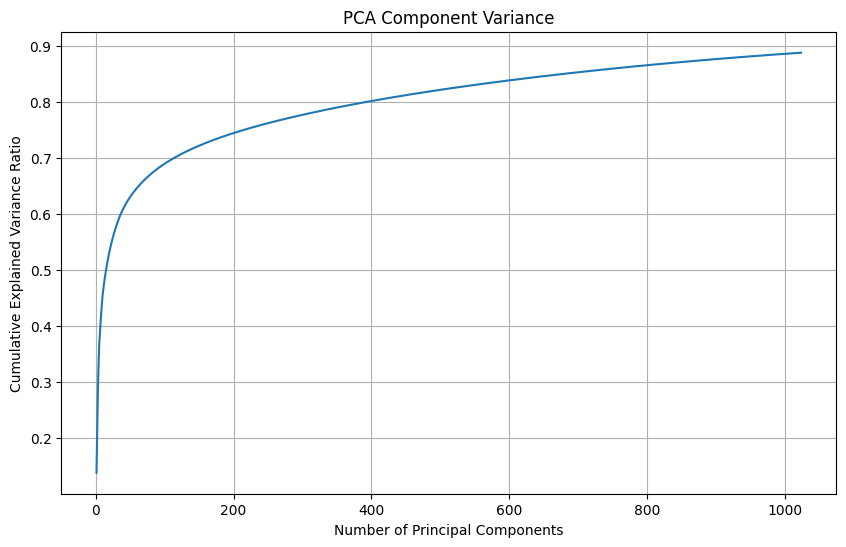

In [8]:
# Block 7: PCA Variance Plot
if myDataset and hasattr(myDataset, 'pca') and myDataset.apply_pca:
    explained_variance_ratio = myDataset.pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance Ratio")
    plt.title("PCA Component Variance")
    plt.grid(True)
    plt.show()
else:
    print("PCA not applied or dataset not loaded, skipping variance plot.")

Image batch shape: torch.Size([16, 3, 32, 32])
FMRI PCA batch shape: torch.Size([16, 1024])


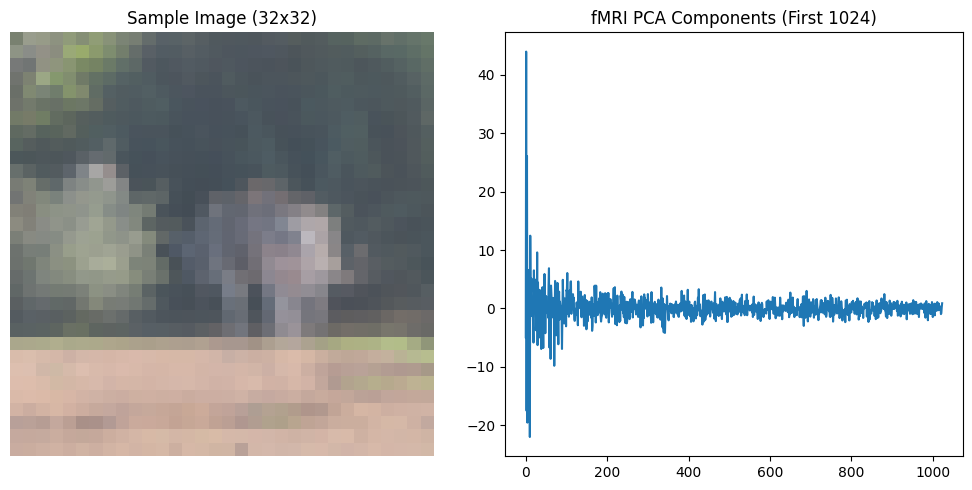

In [9]:
# Block 8: Sample Data Visualization
# ## 7. Sample Data Visualization
if dataloader:
    # Visualize a sample AFTER transformation
    try:
        img_sample, fmri_pca_sample = next(iter(dataloader))
        print(f"Image batch shape: {img_sample.shape}")
        print(f"FMRI PCA batch shape: {fmri_pca_sample.shape}")

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        showImage(ax[0], img_sample[0], f'Sample Image ({image_size}x{image_size})')
        ax[1].plot(fmri_pca_sample[0].cpu().numpy())
        ax[1].set_title(f'fMRI PCA Components (First {fmri_pca_dim})')
        plt.tight_layout()
        plt.show()
    except StopIteration:
        print("DataLoader is empty or failed to yield a batch.")
    except Exception as e:
        print(f"An error occurred during sample visualization: {e}")
else:
    print("Dataloader not available, skipping sample visualization.")

##**Training the generative model**

We start by building our generative model

In [10]:
# Block 9: Model Definitions (cGAN)
# ## 8. Model Definitions (cGAN)

# --- cGAN Generator ---
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc, fmri_pca_dim, embed_dim):
        super(Generator, self).__init__()
        self.fmri_embed = nn.Linear(fmri_pca_dim, embed_dim) # Embedding layer for fMRI
        self.main = nn.Sequential(
            # input is Z + C_embed, going into a convolution
            nn.ConvTranspose2d( nz + embed_dim, ngf * 4, 4, 1, 0, bias=False), # Adjusted ngf factor
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, noise, fmri_condition):
        # Embed fmri condition and reshape
        fmri_embedded = self.fmri_embed(fmri_condition).view(-1, embed_dim, 1, 1)
        # Concatenate noise and embedded condition
        combined_input = torch.cat([noise, fmri_embedded], 1)
        return self.main(combined_input)


# --- cGAN Discriminator ---
class Discriminator(nn.Module):
    def __init__(self, nc, ndf, fmri_pca_dim, embed_dim):
        super(Discriminator, self).__init__()
        self.fmri_embed = nn.Linear(fmri_pca_dim, embed_dim) # Embedding layer for fMRI

        self.main = nn.Sequential(
            # input is (nc + embed_dim) x 32 x 32
            nn.Conv2d(nc + embed_dim, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, fmri_condition):
        # Embed fmri condition and reshape for spatial concatenation
        fmri_embedded = self.fmri_embed(fmri_condition).view(-1, embed_dim, 1, 1)
        fmri_embedded_spatial = fmri_embedded.repeat(1, 1, img.size(2), img.size(3)) # Repeat to match image H, W

        # Concatenate image and embedded condition along channel dimension
        combined_input = torch.cat([img, fmri_embedded_spatial], 1)
        output = self.main(combined_input)
        return output.view(-1) # Flatten output

In [11]:
# Block 10: Model Initialization & Optimizers
# ## 9. Model Initialization & Optimizers

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Initialize models (uses updated fmri_pca_dim=1024)
netG = Generator(nz, ngf, nc, fmri_pca_dim, embed_dim).to(device)
netG.apply(weights_init)

netD = Discriminator(nc, ndf, fmri_pca_dim, embed_dim).to(device)
netD.apply(weights_init)

# Print model summaries
# print("--- Generator ---")
dummy_noise_g = torch.randn(1, nz, 1, 1).to(device)
dummy_condition_g = torch.randn(1, fmri_pca_dim).to(device) # Use updated dim
# summary(netG, input_data=[dummy_noise_g, dummy_condition_g])

# print("\n--- Discriminator ---")
dummy_img_d = torch.randn(1, nc, image_size, image_size).to(device)
dummy_condition_d = torch.randn(1, fmri_pca_dim).to(device) # Use updated dim
# summary(netD, input_data=[dummy_img_d, dummy_condition_d])

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Fixed noise and fixed condition batch for visualization (10 images)
num_preview_images = 10
fixed_noise = None
fixed_condition_batch = None

if myDataset and len(myDataset) > 0 :
    actual_preview_size = min(num_preview_images, len(myDataset))
    if actual_preview_size > 0:
        try:
            # Get the first 'actual_preview_size' conditions and generate fixed noise
            # Since data is preloaded, we can access it directly
            fixed_condition_list = [myDataset[i][1] for i in range(actual_preview_size)]
            fixed_condition_batch = torch.stack(fixed_condition_list).to(device)
            fixed_noise = torch.randn(actual_preview_size, nz, 1, 1, device=device)

            print(f"Fixed noise shape for visualization: {fixed_noise.shape}")
            print(f"Fixed condition batch shape for visualization: {fixed_condition_batch.shape}")
        except Exception as e:
            print(f"Error creating fixed batch from preloaded data: {e}")
    else:
        print("Dataset is empty, cannot create fixed batch for preview.")
else:
    if not myDataset:
        print("myDataset is not initialized. Skipping fixed batch creation.")
    elif len(myDataset) == 0 :
        print("Dataset is empty. Skipping fixed batch creation.")


if fixed_condition_batch is None or fixed_noise is None:
    print("Warning: fixed_noise or fixed_condition_batch is None. Preview generation will be skipped.")

Fixed noise shape for visualization: torch.Size([10, 100, 1, 1])
Fixed condition batch shape for visualization: torch.Size([10, 1024])


Starting Training Loop...


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 2/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 3/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 4/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 5/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 6/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 7/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 8/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 9/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 10/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 11/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 12/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 13/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 14/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 15/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 16/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 17/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 18/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 19/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 20/500:   0%|          | 0/616 [00:00<?, ?it/s]


Generating preview after Epoch 20...


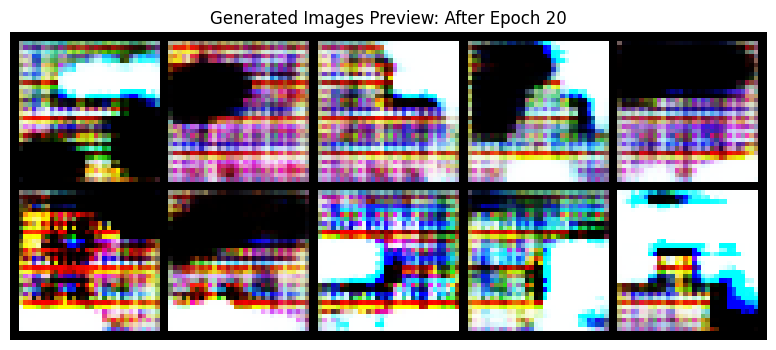

Epoch 21/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 22/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 23/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 24/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 25/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 26/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 27/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 28/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 29/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 30/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 31/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 32/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 33/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 34/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 35/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 36/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 37/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 38/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 39/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 40/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 41/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 42/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 43/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 44/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 45/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 46/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 47/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 48/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 49/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 50/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 51/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 52/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 53/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 54/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 55/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 56/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 57/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 58/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 59/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 60/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 61/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 62/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 63/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 64/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 65/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 66/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 67/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 68/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 69/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 70/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 71/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 72/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 73/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 74/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 75/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 76/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 77/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 78/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 79/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 80/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 81/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 82/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 83/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 84/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 85/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 86/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 87/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 88/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 89/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 90/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 91/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 92/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 93/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 94/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 95/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 96/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 97/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 98/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 99/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 100/500:   0%|          | 0/616 [00:00<?, ?it/s]


Saving checkpoint at Epoch 100...
Checkpoint saved to: /content/drive/MyDrive/DNN/Assesment/GAN_Models_Optimized/cgan_checkpoint_subj1_hem1_epoch100.pth


Epoch 101/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 102/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 103/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 104/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 105/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 106/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 107/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 108/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 109/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 110/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 111/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 112/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 113/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 114/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 115/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 116/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 117/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 118/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 119/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 120/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 121/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 122/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 123/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 124/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 125/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 126/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 127/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 128/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 129/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 130/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 131/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 132/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 133/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 134/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 135/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 136/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 137/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 138/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 139/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 140/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 141/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 142/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 143/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 144/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 145/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 146/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 147/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 148/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 149/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 150/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 151/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 152/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 153/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 154/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 155/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 156/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 157/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 158/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 159/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 160/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 161/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 162/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 163/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 164/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 165/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 166/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 167/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 168/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 169/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 170/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 171/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 172/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 173/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 174/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 175/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 176/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 177/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 178/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 179/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 180/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 181/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 182/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 183/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 184/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 185/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 186/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 187/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 188/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 189/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 190/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 191/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 192/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 193/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 194/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 195/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 196/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 197/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 198/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 199/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 200/500:   0%|          | 0/616 [00:00<?, ?it/s]


Saving checkpoint at Epoch 200...
Checkpoint saved to: /content/drive/MyDrive/DNN/Assesment/GAN_Models_Optimized/cgan_checkpoint_subj1_hem1_epoch200.pth


Epoch 201/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 202/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 203/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 204/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 205/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 206/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 207/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 208/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 209/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 210/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 211/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 212/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 213/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 214/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 215/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 216/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 217/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 218/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 219/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 220/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 221/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 222/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 223/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 224/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 225/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 226/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 227/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 228/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 229/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 230/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 231/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 232/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 233/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 234/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 235/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 236/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 237/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 238/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 239/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 240/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 241/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 242/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 243/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 244/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 245/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 246/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 247/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 248/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 249/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 250/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 251/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 252/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 253/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 254/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 255/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 256/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 257/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 258/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 259/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 260/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 261/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 262/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 263/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 264/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 265/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 266/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 267/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 268/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 269/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 270/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 271/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 272/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 273/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 274/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 275/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 276/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 277/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 278/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 279/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 280/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 281/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 282/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 283/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 284/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 285/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 286/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 287/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 288/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 289/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 290/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 291/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 292/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 293/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 294/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 295/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 296/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 297/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 298/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 299/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 300/500:   0%|          | 0/616 [00:00<?, ?it/s]


Saving checkpoint at Epoch 300...
Checkpoint saved to: /content/drive/MyDrive/DNN/Assesment/GAN_Models_Optimized/cgan_checkpoint_subj1_hem1_epoch300.pth


Epoch 301/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 302/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 303/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 304/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 305/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 306/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 307/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 308/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 309/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 310/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 311/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 312/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 313/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 314/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 315/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 316/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 317/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 318/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 319/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 320/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 321/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 322/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 323/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 324/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 325/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 326/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 327/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 328/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 329/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 330/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 331/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 332/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 333/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 334/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 335/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 336/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 337/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 338/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 339/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 340/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 341/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 342/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 343/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 344/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 345/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 346/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 347/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 348/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 349/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 350/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 351/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 352/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 353/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 354/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 355/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 356/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 357/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 358/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 359/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 360/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 361/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 362/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 363/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 364/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 365/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 366/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 367/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 368/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 369/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 370/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 371/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 372/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 373/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 374/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 375/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 376/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 377/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 378/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 379/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 380/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 381/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 382/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 383/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 384/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 385/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 386/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 387/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 388/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 389/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 390/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 391/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 392/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 393/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 394/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 395/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 396/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 397/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 398/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 399/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 400/500:   0%|          | 0/616 [00:00<?, ?it/s]


Saving checkpoint at Epoch 400...
Checkpoint saved to: /content/drive/MyDrive/DNN/Assesment/GAN_Models_Optimized/cgan_checkpoint_subj1_hem1_epoch400.pth


Epoch 401/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 402/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 403/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 404/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 405/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 406/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 407/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 408/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 409/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 410/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 411/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 412/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 413/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 414/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 415/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 416/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 417/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 418/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 419/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 420/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 421/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 422/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 423/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 424/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 425/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 426/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 427/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 428/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 429/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 430/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 431/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 432/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 433/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 434/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 435/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 436/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 437/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 438/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 439/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 440/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 441/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 442/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 443/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 444/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 445/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 446/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 447/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 448/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 449/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 450/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 451/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 452/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 453/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 454/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 455/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 456/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 457/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 458/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 459/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 460/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 461/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 462/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 463/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 464/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 465/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 466/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 467/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 468/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 469/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 470/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 471/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 472/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 473/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 474/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 475/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 476/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 477/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 478/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 479/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 480/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 481/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 482/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 483/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 484/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 485/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 486/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 487/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 488/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 489/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 490/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 491/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 492/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 493/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 494/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 495/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 496/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 497/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 498/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 499/500:   0%|          | 0/616 [00:00<?, ?it/s]

Epoch 500/500:   0%|          | 0/616 [00:00<?, ?it/s]


Generating preview after Epoch 500...


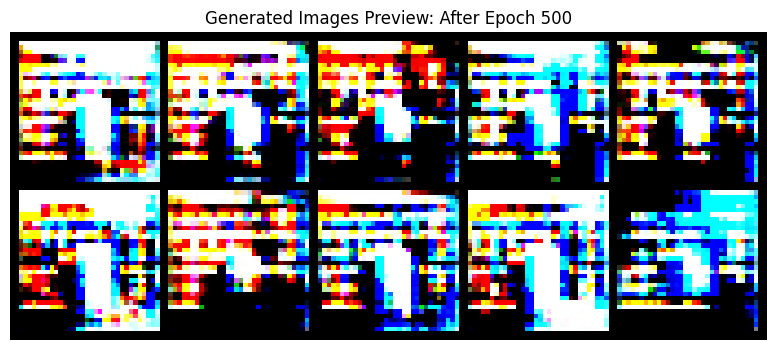


Saving checkpoint at Epoch 500...
Checkpoint saved to: /content/drive/MyDrive/DNN/Assesment/GAN_Models_Optimized/cgan_checkpoint_subj1_hem1_epoch500.pth
--- Training Finished in 01:15:18 ---


In [12]:
# Block 11: Training Loop (with Epoch-based Preview and Checkpointing)
# ## 10. Training Loop (cGAN)
num_epochs = 500      # Number of training epochs (adjust as needed)
if dataloader: # Only proceed if dataloader was successfully created
    # Lists to store losses and generated images
    G_losses = []
    D_losses = []
    img_list = [] # Stores preview images generated at specific epochs
    iters = 0

    print("Starting Training Loop...")
    start_time = time.time()

    epoch_pbar = tqdm(range(num_epochs), desc="Epochs")
    for epoch in epoch_pbar:
        epoch_start_time = time.time()
        netG.train() # Ensure models are in train mode at the start of epoch
        netD.train()

        batch_pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for i, data in enumerate(batch_pbar, 0):
            # ---------------------
            # (1) Update D network
            # ---------------------
            netD.zero_grad()
            real_imgs = data[0].to(device)
            conditions = data[1].to(device)
            b_size = real_imgs.size(0)
            if b_size == 0: continue

            label = torch.full((b_size,), 1., dtype=torch.float, device=device)
            output_real = netD(real_imgs, conditions).view(-1)
            errD_real = criterion(output_real, label)
            errD_real.backward()
            D_x = output_real.mean().item()

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise, conditions)
            label.fill_(0.)
            output_fake = netD(fake.detach(), conditions).view(-1)
            errD_fake = criterion(output_fake, label)
            errD_fake.backward()
            D_G_z1 = output_fake.mean().item()

            errD = errD_real + errD_fake
            optimizerD.step()

            # ---------------------
            # (2) Update G network
            # ---------------------
            netG.zero_grad()
            label.fill_(1.)
            # Re-generate fake images for G's update step is safer
            fake_for_G = netG(noise, conditions) # Reuse noise/conditions for efficiency here
            output_gen = netD(fake_for_G, conditions).view(-1)
            errG = criterion(output_gen, label)
            errG.backward()
            D_G_z2 = output_gen.mean().item()
            optimizerG.step()

            G_losses.append(errG.item())
            D_losses.append(errD.item())

            if i % 100 == 0 or i == len(dataloader) - 1: # Update less frequently maybe
                 batch_pbar.set_postfix(Loss_D=f'{errD.item():.4f}', Loss_G=f'{errG.item():.4f}', D_x=f'{D_x:.4f}', D_G_z=f'{D_G_z2:.4f}')

            iters += 1
        # --- End of Inner Loop (Batches) ---
        batch_pbar.close()

        # --- Preview Check (After Epoch 20 and Last Epoch) ---
        if (epoch + 1) == 20 or (epoch + 1) == num_epochs:
             if fixed_noise is not None and fixed_condition_batch is not None and \
                fixed_condition_batch.size(0) == fixed_noise.size(0) and fixed_noise.size(0) > 0 :
                 print(f"\nGenerating preview after Epoch {epoch+1}...")
                 with torch.no_grad():
                     netG.eval() # Set to eval mode for consistent preview
                     fake_vis = netG(fixed_noise, fixed_condition_batch).detach().cpu()
                     netG.train() # Set back to train mode
                 img_grid = vutils.make_grid(fake_vis, padding=2, normalize=True, nrow=5) # 2x5 grid
                 img_list.append(img_grid) # Save grid for potential later use/plotting

                 plt.figure(figsize=(10,4))
                 plt.axis("off")
                 plt.title(f"Generated Images Preview: After Epoch {epoch+1}")
                 plt.imshow(img_grid.permute(1, 2, 0))
                 plt.show()
             else:
                 print(f"Skipping preview after Epoch {epoch+1} due to missing/mismatched fixed batch.")

        # --- Checkpoint Saving (Every 100 Epochs and Last Epoch) ---
        if (epoch + 1) % 100 == 0 or (epoch + 1) == num_epochs:
            print(f"\nSaving checkpoint at Epoch {epoch+1}...")
            checkpoint = {
                'epoch': epoch + 1,
                'netG_state_dict': netG.state_dict(),
                'netD_state_dict': netD.state_dict(),
                'optimizerG_state_dict': optimizerG.state_dict(),
                'optimizerD_state_dict': optimizerD.state_dict(),
                'g_losses': G_losses, # Save all losses up to this point
                'd_losses': D_losses,
                'iters': iters,
                # Include any other parameters you might want to save
                'params': {
                    'nz': nz, 'ngf': ngf, 'ndf': ndf, 'nc': nc,
                    'fmri_pca_dim': fmri_pca_dim, 'embed_dim': embed_dim,
                    'image_size': image_size, 'lr': lr, 'beta1': beta1,
                    'batch_size': batch_size, 'subject': subject, 'hemisphere': hemisphere
                 }
            }
            chkpt_filename = os.path.join(save_path, f"cgan_checkpoint_subj{subject}_hem{hemisphere}_epoch{epoch+1}.pth")
            try:
                torch.save(checkpoint, chkpt_filename)
                print(f"Checkpoint saved to: {chkpt_filename}")
            except Exception as e:
                print(f"Error saving checkpoint: {e}")

    # --- End of Outer Loop (Epochs) ---
    epoch_pbar.close()

    total_training_time = time.time() - start_time
    print(f"--- Training Finished in {time.strftime('%H:%M:%S', time.gmtime(total_training_time))} ---")
else:
    print("Dataloader not initialized. Skipping training loop.")

In [13]:
# Block 12: Save Final Models
# ## 11. Save Final Models (Separate from Checkpoints)
if dataloader and 'iters' in locals() and iters > 0: # Check if training actually happened
    print("\n--- Saving Final Models ---")
    # Use a distinct name for the absolute final model state
    final_gen_save_file = os.path.join(save_path, f"cgan_generator_subj{subject}_hem{hemisphere}_FINAL.pth")
    final_disc_save_file = os.path.join(save_path, f"cgan_discriminator_subj{subject}_hem{hemisphere}_FINAL.pth")

    try:
        torch.save(netG.state_dict(), final_gen_save_file)
        torch.save(netD.state_dict(), final_disc_save_file)
        print(f"Final Generator state dict saved to: {final_gen_save_file}")
        print(f"Final Discriminator state dict saved to: {final_disc_save_file}")
    except Exception as e:
        print(f"Error saving final models: {e}")
else:
    print("Skipping final model saving as training did not run or complete.")


--- Saving Final Models ---
Final Generator state dict saved to: /content/drive/MyDrive/DNN/Assesment/GAN_Models_Optimized/cgan_generator_subj1_hem1_FINAL.pth
Final Discriminator state dict saved to: /content/drive/MyDrive/DNN/Assesment/GAN_Models_Optimized/cgan_discriminator_subj1_hem1_FINAL.pth


In [14]:
# ## 11. Save Models
print("\n--- Saving Models ---")
gen_save_file = os.path.join(save_path, f"cgan_generator_subj{subject}_hem{hemisphere}.pth")
disc_save_file = os.path.join(save_path, f"cgan_discriminator_subj{subject}_hem{hemisphere}.pth")

try:
    torch.save(netG.state_dict(), gen_save_file)
    torch.save(netD.state_dict(), disc_save_file)
    print(f"Generator state dict saved to: {gen_save_file}")
    print(f"Discriminator state dict saved to: {disc_save_file}")
except Exception as e:
    print(f"Error saving models: {e}")


--- Saving Models ---
Generator state dict saved to: /content/drive/MyDrive/DNN/Assesment/GAN_Models_Optimized/cgan_generator_subj1_hem1.pth
Discriminator state dict saved to: /content/drive/MyDrive/DNN/Assesment/GAN_Models_Optimized/cgan_discriminator_subj1_hem1.pth



--- Plotting Loss Curves ---


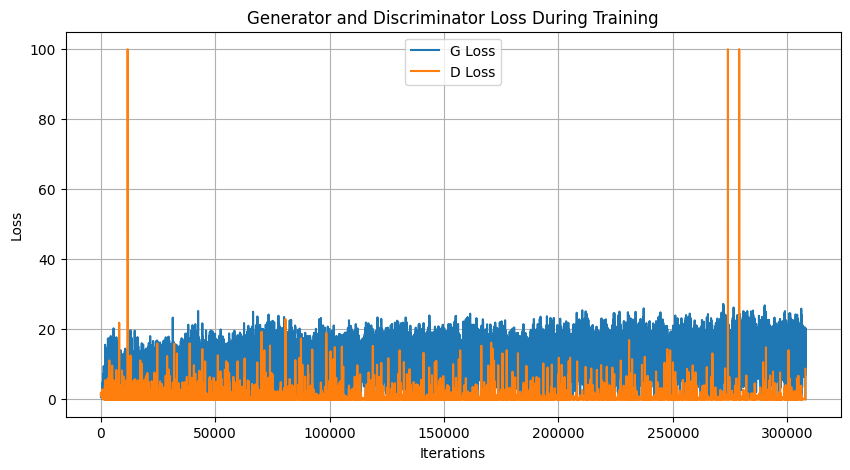

In [15]:
# Block 13: Training Evaluation - Loss Curves
# ## 12. Training Evaluation

# ### 12.1. Loss Curves
if G_losses and D_losses:
    print("\n--- Plotting Loss Curves ---")
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G Loss")
    plt.plot(D_losses, label="D Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No loss data to plot.")


--- Final Generated Images Grid ---


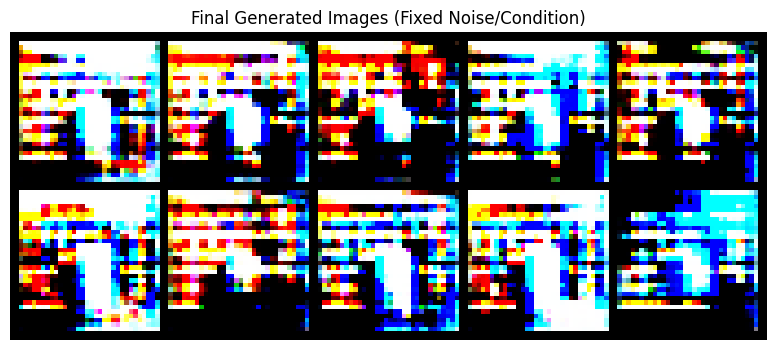

In [16]:
# Block 14: Final Generated Images Grid
# ### 12.2. Final Generated Images (from fixed noise/condition)
if img_list:
    print("\n--- Final Generated Images Grid ---")
    # Adjust figsize if you know it's 10 images, e.g., for a 2x5 or 5x2 grid
    # The nrow in make_grid in the training loop controls the grid layout.
    # If nrow=5, for 10 images, it's 2 rows.
    plt.figure(figsize=(10, 4) if num_preview_images == 10 and len(img_list[-1]) > 0 and img_list[-1].size(0) == 3 else (8,8) )
    plt.axis("off")
    plt.title("Final Generated Images (Fixed Noise/Condition)")
    plt.imshow(img_list[-1].permute(1, 2, 0)) # Display the last saved grid
    plt.show()
else:
     print("No preview images were saved during training to display.")


--- Comparing Real and Final Fake Images ---


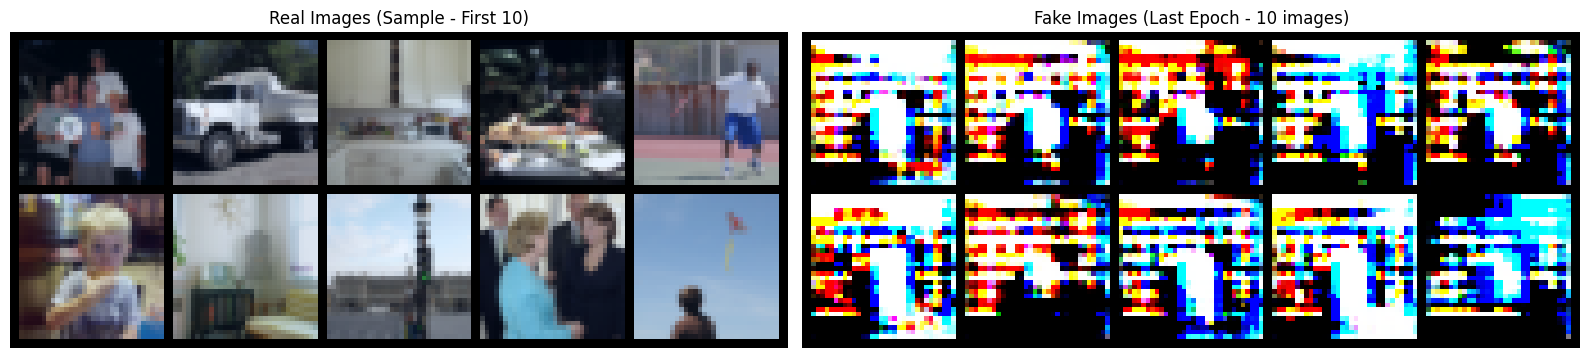

In [17]:
# Block 15: Real vs. Fake Image Comparison
# ### 12.3. Real vs. Fake Image Comparison
if dataloader and img_list:
    print("\n--- Comparing Real and Final Fake Images ---")
    try:
        temp_dataloader_iter_real_fake = iter(dataloader)
        real_batch_viz, _ = next(temp_dataloader_iter_real_fake)
        del temp_dataloader_iter_real_fake

        plt.figure(figsize=(16, 8)) # You might adjust this based on 10 images

        plt.subplot(1, 2, 1)
        plt.axis("off")
        plt.title(f"Real Images (Sample - First {num_preview_images})")
        # Show the same number of real images as in the preview
        plt.imshow(vutils.make_grid(real_batch_viz.to(device)[:num_preview_images], padding=2, normalize=True, nrow=5).cpu().permute(1,2,0))

        plt.subplot(1, 2, 2)
        plt.axis("off")
        plt.title(f"Fake Images (Last Epoch - {num_preview_images} images)")
        plt.imshow(img_list[-1].permute(1,2,0)) # This grid is already for num_preview_images
        plt.tight_layout()
        plt.show()
    except StopIteration:
        print("Could not load a batch for real vs fake comparison (dataloader might be exhausted).")
    except Exception as e:
         print(f"An error occurred during real vs fake comparison: {e}")
else:
    print("Skipping real vs fake comparison (dataloader or image list not available).")


--- Evaluating Reconstruction Quality ---
Using first 8 samples from fixed batch for reconstruction.


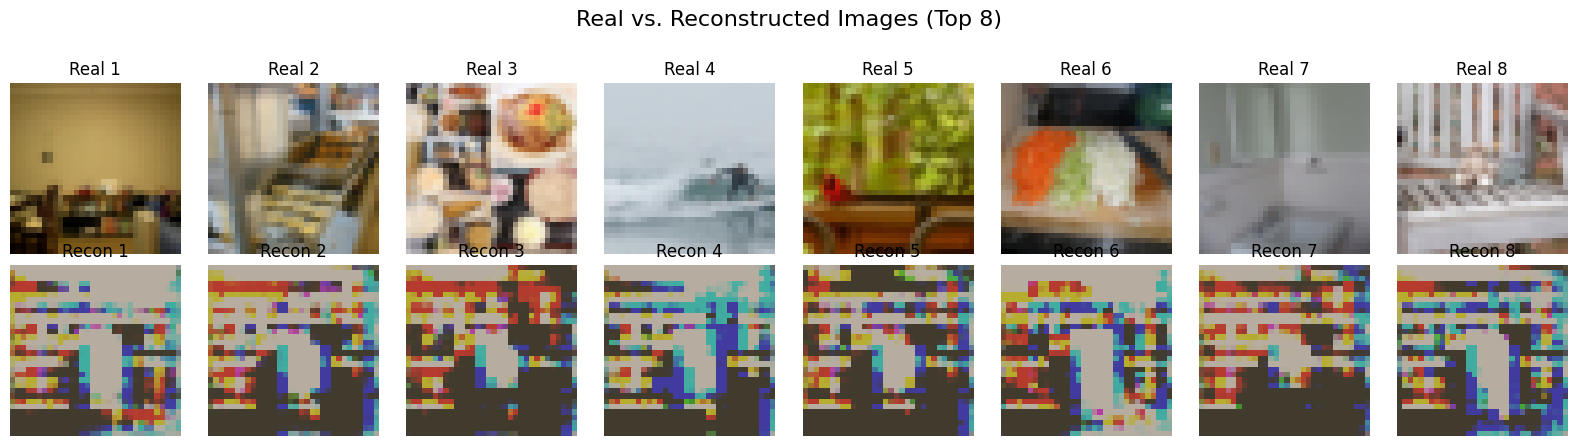


--- Final Training Summary ---
Trained on Subject: 1, Hemisphere: Left
PCA Dim: 1024, Batch Size: 16
Total Epochs Trained: 500
Total Iterations: 308000
Final Generator Loss: 0.0000
Final Discriminator Loss: 8.6822
Dataset Size Used: 9841
Training completed in: 01:15:18

--- End of Notebook ---


In [18]:
# Block 16: Reconstruction Evaluation
# ## 13. Reconstruction Evaluation (Qualitative)

if myDataset and dataloader:
    print("\n--- Evaluating Reconstruction Quality ---")
    # Let's use a smaller batch for eval, e.g., 8
    eval_batch_size = 8
    if fixed_noise is not None and fixed_condition_batch is not None:
        eval_batch_size = min(eval_batch_size, fixed_noise.size(0), fixed_condition_batch.size(0))
    elif myDataset:
         eval_batch_size = min(eval_batch_size, len(myDataset))
    else:
        eval_batch_size = 0

    if eval_batch_size > 0:
        try:
            # Get eval data (can use fixed batch portion or new data)
            # Using fixed batch portion for consistency with preview if available
            if fixed_condition_batch is not None and fixed_noise is not None and \
               fixed_condition_batch.size(0) >= eval_batch_size and \
               fixed_noise.size(0) >= eval_batch_size:

                print(f"Using first {eval_batch_size} samples from fixed batch for reconstruction.")
                conditions_eval = fixed_condition_batch[:eval_batch_size].to(device)
                recon_noise_eval = fixed_noise[:eval_batch_size].to(device)
                # Get corresponding real images from preloaded data
                real_eval_imgs_list = [myDataset[i][0] for i in range(eval_batch_size)]
                real_eval_imgs = torch.stack(real_eval_imgs_list).to(device)

            else:
                # Load a fresh batch (less ideal for comparing to fixed preview)
                print("Fixed batch not suitable/available. Loading a new batch for reconstruction.")
                temp_eval_loader = DataLoader(myDataset, batch_size=eval_batch_size, shuffle=False, num_workers=0)
                real_eval_imgs_batch, conditions_eval_batch = next(iter(temp_eval_loader))
                real_eval_imgs = real_eval_imgs_batch.to(device)
                conditions_eval = conditions_eval_batch.to(device)
                recon_noise_eval = torch.randn(eval_batch_size, nz, 1, 1, device=device)
                del temp_eval_loader

            # Generate reconstructed images
            netG.eval()
            with torch.no_grad():
                reconstructed_images = netG(recon_noise_eval, conditions_eval).detach().cpu()
            netG.train()

            # Visualize
            cols = eval_batch_size
            fig_width = max(16, cols * 2)
            fig_height = 4.5
            fig, axes = plt.subplots(2, cols, figsize=(fig_width, fig_height))

            fig.suptitle(f"Real vs. Reconstructed Images (Top {eval_batch_size})", fontsize=16)
            for i in range(eval_batch_size):
                showImage(axes[0, i], real_eval_imgs[i], f"Real {i+1}")
                showImage(axes[1, i], reconstructed_images[i], f"Recon {i+1}")

            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()

        except StopIteration:
            print("Could not load a batch for reconstruction evaluation.")
        except Exception as e:
            print(f"An error occurred during reconstruction evaluation: {e}")
    else:
        print("Eval batch size is 0, skipping reconstruction evaluation.")
else:
    print("Dataset or Dataloader not available, skipping reconstruction evaluation.")

# ... (rest of the evaluation blocks remain largely the same) ...

# ## 14. Final Training Summary Report
if 'iters' in locals() and iters > 0 : # Check if training loop ran
    print("\n--- Final Training Summary ---")
    print(f"Trained on Subject: {subject}, Hemisphere: {'Left' if hemisphere == 1 else 'Right'}")
    print(f"PCA Dim: {fmri_pca_dim}, Batch Size: {batch_size}") # Add info
    print(f"Total Epochs Trained: {num_epochs}")
    print(f"Total Iterations: {iters}")
    if G_losses and D_losses:
        print(f"Final Generator Loss: {G_losses[-1]:.4f}")
        print(f"Final Discriminator Loss: {D_losses[-1]:.4f}")
    else:
        print("Loss data not available (training might have been too short or skipped).")
    if myDataset:
        print(f"Dataset Size Used: {len(myDataset)}")
    if 'total_training_time' in locals():
        print(f"Training completed in: {time.strftime('%H:%M:%S', time.gmtime(total_training_time))}")
else:
    print("Training loop did not run or complete. No summary to report.")

print("\n--- End of Notebook ---")